opening file...
finished opening
[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  7.36455e-03  0.00000e+00  0.00000e+00  1.47291e-02  0.00000e+00
  0.00000e+00  2.20936e-02 -5.12222e-05  9.16963e-05  2.94572e-02
 -2.11680e-04  3.79501e-04  3.68141e-02 -4.72569e-04  8.75683e-04
  4.41569e-02 -7.97554e-04  1.63228e-03  5.14748e-02 -1.18193e-03
  2.65438e-03  5.87575e-02 -1.53628e-03  3.88510e-03  6.60096e-02
 -1.78105e-03  5.27394e-03  7.32377e-02 -1.87273e-03  6.86423e-03
  8.04273e-02 -1.76204e-03  8.70025e-03  8.75577e-02 -1.33082e-03
  1.08639e-02  9.45825e-02 -5.52282e-04  1.33663e-02  1.01463e-01
  5.69896e-04  1.61958e-02  1.08168e-01  2.03041e-03  1.93390e-02
  1.14664e-01  3.82237e-03  2.27809e-02  1.20922e-01  5.93729e-03
  2.65054e-02  1.26911e-01  8.36520e-03  3.04948e-02  1.32604e-01]
Training set: (800000, 60)
Testing set:  (200000, 60)
_________________________________________________________________
Layer (type)                 Output Shape             

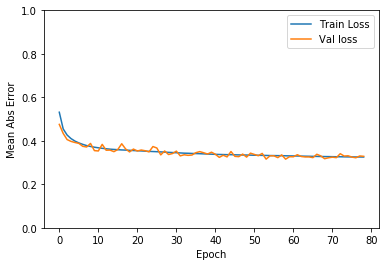

Testing set Mean Abs Error: $0.32951


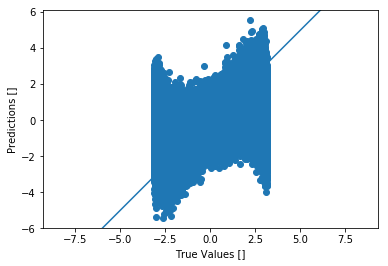

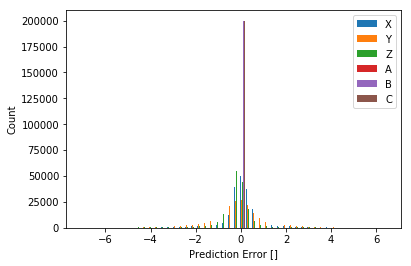

In [5]:
import csv

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import scale
import numpy as np

print('opening file...')
with open('data/shapemap1000000.txt',"r") as f:
    # all_data=[x.split() for x in f.readlines()]
    all_data=[next(f).split() for i in range(3000000)]

    robotInput = np.array([[float(i) for i in x] for x in all_data[::3]], dtype=float)

    coords = np.array([[float(i) for i in x] for x in all_data[2::3]], dtype=float)
print('finished opening')


length = len(coords)
train_data = coords[:length//5*4] # 80%
print(train_data[0])
train_labels = robotInput[:length//5*4] # 80%

test_data = coords[length//5*4:] # last 20%
test_labels = robotInput[length//5*4:] # last 20%

print("Training set: {}".format(train_data.shape))  # xxx examples, 60 features
print("Testing set:  {}".format(test_data.shape))   # xxx examples, 60 features


def build_model():
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.relu,
                           input_shape=(train_data.shape[1],)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(6)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model


model = build_model()
model.summary()


# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

import matplotlib.pyplot as plt


def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
             label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
             label = 'Val loss')
    plt.legend()
    plt.ylim([0, 1])
    plt.savefig('Error_Loss.png')
    plt.show()

plot_history(history)

# PERFORMANCE ON TEST SET

[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: ${:7.5f}".format(mae))

# PREDICTION

test_predictions = model.predict(test_data)#.flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values []')
plt.ylabel('Predictions []')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.savefig('Predictions_v_True.png')
plt.show()

error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.legend(['X','Y','Z','A','B','C'])
plt.xlabel("Prediction Error []")
plt.ylabel("Count")
plt.savefig('X_Y_Z_Error.png')
plt.show()

# print the first few predictions and labels
#for x in range(0, 50):
    #print(test_labels[x], test_predictions[x], sep=" : ")